In [1]:
!pip --quiet install keras
!pip --quiet install h5py
!pip --quiet install shapely
!pip --quiet install descartes
!pip --quiet install tqdm
!pip --quiet install tensorflow

In [1]:
%matplotlib inline
import random
import os
import json
import sys
import string
import unicodedata
from tqdm import tqdm
import pandas as pd
#Numpy and Scipy
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from scipy.spatial import distance
#KERAS
from keras.layers import Dense, Activation,Dropout
from keras.models import Sequential
from keras.regularizers import l1,l2
from keras.models import load_model

Using TensorFlow backend.


In [2]:
#Given local path, find full path
def PathFinder(path):
    script_dir = os.path.dirname('__file__')
    fullpath = os.path.join(script_dir,path)
    return fullpath

#Read Data for Deep Learning
def ReadData(path):
    fullpath=PathFinder(path)
    return pd.read_csv(fullpath, sep=',', header=0)

#Input Normalization
def Normalize(features, mean = [], std = []):
    if mean == []:
        mean = np.mean(features, axis = 0)
        std = np.std(features, axis = 0)
#     print std
#     print std[:,None]
    new_feature = (features.T - mean[:,None]).T
    new_feature = (new_feature.T / std[:,None]).T
    new_feature[np.isnan(new_feature)]=0
#     print new_feature
    return new_feature, mean, std

In [3]:
import tensorflow as tf
tf.python.control_flow_ops = tf
from keras.layers import Input, Dense,merge
from keras.models import Model
from keras import backend as K
class DenselyConnectedNetwork(object):
    '''

    '''
    def __init__(self,observ,hidden,output,num_layers,drop_out,boost):
        self.drop_out=drop_out
        self.boost = boost

        inputs = Input(shape=(observ,))
        if num_layers == 0:
            interm_inputs=inputs;
        
        if num_layers >= 1:
            x = Dense(hidden, activation='relu')(inputs)
            x = Dropout(drop_out)(x)
            interm_inputs = merge([x,inputs], mode='concat')
            if num_layers > 1:
                for i in range(num_layers-1):
                    x = Dense(hidden, activation='relu')(interm_inputs)
                    x = Dropout(drop_out)(x)
                    interm_inputs=merge([x, interm_inputs], mode='concat')
#         predictions = Dense(output, activation='linear')(interm_inputs)
#        if num_layers > 1:
#            for i in range(num_layers-1):
#                x = Dense(hidden, activation='relu')(x)
#                x = Dropout(drop_out)(x)
#        interm_inputs=merge([x,inputs], mode='concat')
        predictions = Dense(output, activation='linear')(interm_inputs)
        self.DeepNet=Model(input=inputs, output=predictions)
        self.DeepNet.compile(optimizer='rmsprop', loss=self.boosted_mean_squared_error)
        
    def boosted_mean_squared_error(self,y_true, y_pred):
        return K.mean(K.square(y_pred - y_true)*self.boost, axis=-1)
    
    def Train(self,data,label,epoch, normalize=False):
        mean=[]
        std=[]
        if normalize:
            normalized_data,mean,std=Normalize(data)
        else:
            normalized_data=data
        self.history=self.DeepNet.fit(normalized_data, label,validation_split=0.1,batch_size=128, nb_epoch=epoch)
        return mean,std

    def Test(self,datapoint,normalize=False,mean=[],std=[]):
        if normalize:
            normalized_datapoint,_,_=Normalize(datapoint,mean,std)
        else:
            normalized_datapoint=datapoint
        return self.DeepNet.predict(normalized_datapoint, batch_size=128, verbose=0)
    
    def LoadModel(self,modelpath):
        self.DeepNet=load_model(modelpath)
    
    def Save(self,modelpath):
        self.DeepNet.save(modelpath)
        
    def GetModel(self):
        return self.DeepNet
    
    def ShowHistory(self):
        # summarize history for loss
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        #plt.legend(['train', 'test'], loc='upper left')
        plt.savefig('train_curve.png')

In [48]:
from matplotlib.ticker import ScalarFormatter
def performanceViz(Data,True_Label,Pred_Label1,Pred_Label2,Pred_Label3,horizon):
    _,dim=Data.shape
    fig, axes = plt.subplots(nrows=dim, ncols=1, figsize=(4, 4))
    y_formatter = ScalarFormatter(useOffset=False)
    for i in range(dim):
        for j in range(horizon):
            axes[i].plot([j,j+1],[Data[j,i],True_Label[j,i]],'r-',lw=1.5)
            axes[i].plot([j,j+1],[Data[j,i],Pred_Label1[j,i]],'b-.',lw=1.5)
            axes[i].plot([j,j+1],[Data[j,i],Pred_Label2[j,i]],'m-.',lw=1.5)
            axes[i].plot([j,j+1],[Data[j,i],Pred_Label3[j,i]],'k-.',lw=1.5)
            axes[i].locator_params(axis='y',nbins=2)
            axes[i].yaxis.tick_right()
            if(i!=dim-1):
                axes[i].tick_params(axis='x', which='both',bottom='off',top='off',labelbottom='off',length=0)
        axes[0].set_ylabel('Temp1')
        axes[1].set_ylabel('Temp2')
        axes[2].set_ylabel('Temp3')
        axes[3].set_ylabel('Air1')
        axes[4].set_ylabel('Air2')
        axes[5].set_ylabel('Air3')
        plt.xlabel('Time Step')
    fig.subplots_adjust(hspace=0.4)
    plt.savefig('Comparison.eps',format='eps')


In [12]:
def performanceCheck(DNN1,DNN2,DNN3,Test_Data,Test_Label,mean_DNN,std_DNN):
    Pred_Label1 = DNN1.Test(Test_Data,True,mean_DNN,std_DNN)
    Pred_Label2 = DNN2.Test(Test_Data,True,mean_DNN,std_DNN)
    Pred_Label3 = DNN3.Test(Test_Data,True,mean_DNN,std_DNN)
    print "Complete testing"
    Feed_Data=Test_Data[:,3:]
    performanceViz(Feed_Data,Test_Label,Pred_Label1,Pred_Label2,Pred_Label3,10)

In [15]:
def trainNetForData(Datapath,Labelpath,node_size,epoches):
    PD_Data = ReadData(Datapath)
    PD_Label = ReadData(Labelpath)
    Full_Data=PD_Data.as_matrix()
    Full_Label=PD_Label.as_matrix()
    indecs=np.random.permutation(len(Full_Data))
    Full_Data=Full_Data[indecs]
    Full_Label=Full_Label[indecs]
    m_data,n_data=Full_Data.shape
    m_label,n_label=Full_Label.shape
    Train_Data = Full_Data[:int(m_data*0.9)]
    Train_Label = Full_Label[:int(m_data*0.9)]
    Label_Weights = (1.0/np.square(np.max(Train_Label,axis=0)+1))*10
    Test_Data = Full_Data[int(m_data*0.9):]
    Test_Label = Full_Label[int(m_data*0.9):]    
    #LINEAR
    DNN1=DenselyConnectedNetwork(n_data,node_size,n_label,0,0.1,Label_Weights)
    mean_DNN,std_DNN=DNN1.Train(Train_Data, Train_Label,epoches,True)
    DNN1.ShowHistory()
    #SINGLE
    DNN2=DenselyConnectedNetwork(n_data,node_size,n_label,1,0.1,Label_Weights)
    mean_DNN,std_DNN=DNN2.Train(Train_Data, Train_Label,epoches,True)
    DNN2.ShowHistory()
    #DOUBLE
    DNN3=DenselyConnectedNetwork(n_data,node_size,n_label,2,0.1,Label_Weights)
    mean_DNN,std_DNN=DNN3.Train(Train_Data, Train_Label,epoches,True)
    DNN3.ShowHistory()
    plt.legend(['Train-0-Hidden', 'Test-0-Hidden','Train-1-Hidden', 'Test-1-Hidden','Train-2-Hidden', 'Test-2-Hidden'], loc='upper left')
    plt.savefig('train_curve.png')
    return DNN1,DNN2,DNN3,Test_Data,Test_Label,mean_DNN,std_DNN

Datapath="HVAC_VAV_Data.txt"
Labelpath="HVAC_VAV_Label.txt"
DNN1,DNN2,DNN3,Test_Data,Test_Label,mean_DNN,std_DNN=trainNetForData(Datapath,Labelpath,32,100)
performanceCheck(DNN1,DNN2,DNN3,Test_Data,Test_Label,mean_DNN,std_DNN)

Train on 64800 samples, validate on 7200 samples
Epoch 1/100
64800/64800 [==============================] - 0s - loss: 4.4486 - val_loss: 4.1575
Epoch 2/100
64800/64800 [==============================] - 0s - loss: 3.9860 - val_loss: 3.8311
Epoch 3/100
64800/64800 [==============================] - 0s - loss: 3.6942 - val_loss: 3.5649
Epoch 4/100
64800/64800 [==============================] - 0s - loss: 3.4488 - val_loss: 3.3381
Epoch 5/100
64800/64800 [==============================] - 0s - loss: 3.2390 - val_loss: 3.1438
Epoch 6/100
64800/64800 [==============================] - 0s - loss: 3.0561 - val_loss: 2.9717
Epoch 7/100
64800/64800 [==============================] - 0s - loss: 2.8931 - val_loss: 2.8159
Epoch 8/100
64800/64800 [==============================] - 0s - loss: 2.7423 - val_loss: 2.6693
Epoch 9/100
64800/64800 [==============================] - 0s - loss: 2.5995 - val_loss: 2.5296
Epoch 10/100
64800/64800 [==============================] - 0s - loss: 2.4618 - val_los

KeyboardInterrupt: 

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Complete testing


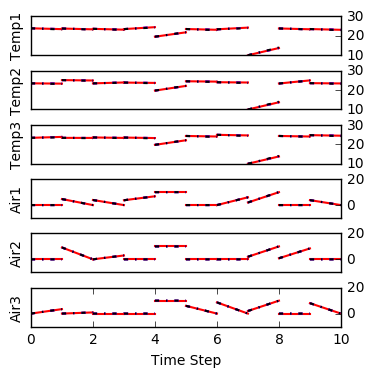

In [49]:
performanceCheck(DNN1,DNN2,DNN3,Test_Data,Test_Label,mean_DNN,std_DNN)